# Baseline Forecast using NIXTLA

### Loading Libraries

In [1]:
%cd ../..

/Users/joaquinromero/Desktop


In [2]:
# Numerical Computing
import numpy as np

# Data Manipulation
import pandas as pd

# Data Visualization
import seaborn as sns
import plotly.io as pio
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# Warnings
import warnings
import humanize

# IO & Requests
import time
import random
import requests
from io import StringIO

# StatsModels
import statsmodels.api as sm
from statsmodels.tsa.seasonal import MSTL , DecomposeResult

# OS
import os
import sys
import pickleshare
import missingno as msno
from itertools import cycle

# PyArrow
import pyarrow as pa

# FuncTools
from functools import partial

# Path & Notebook Optimizer
from pathlib import Path
import missingno as msno
from tqdm.auto import tqdm

# Scikit-Learn
from sklearn.metrics import mean_absolute_error

# IPython
from IPython.display import display, HTML

# NIXTLA
from statsforecast.core import StatsForecast
from utilsforecast.plotting import plot_series
from utilsforecast.evaluation import evaluate

# Forecast
# from datasetsforecast.losses import *
from utilsforecast.evaluation import evaluate
# from statsforecast.losses import mse, mae, mape, rmse, smape, mase

# Custom Libraries
from src.utils import plotting_utils
# from src.utils.ts_utils import forecast_bias

In [3]:
# Custom Libraries
from src.utils import plotting_utils

from src.utils.ts_utils_updated import (
    forecast_bias,
    forecast_bias_aggregate,
    metrics_adapter,
    smape,
    rmse,
    mae,
    mse,
    mase,
    average_length,
)

In [4]:
from statsforecast.models import (
    Naive,
    SeasonalNaive,
    HistoricAverage,
    WindowAverage,
    SeasonalWindowAverage,
    RandomWalkWithDrift,
    HoltWinters,
    AutoETS,
    AutoARIMA,
    ARIMA,
    AutoTheta,
    DynamicTheta,
    DynamicOptimizedTheta,
    Theta,
    OptimizedTheta,
    TBATS,
    AutoTBATS,
    MSTL
)

In [5]:
!pip install statsforecast

In [6]:
%load_ext autoreload
%autoreload 2

In [7]:
tqdm.pandas()

random.seed(42)

np.random.seed(42)

pio.templates.default = "plotly_white"

sys.path.append('/Users/joaquinromero/Desktop/MTSF')

In [8]:
warnings.filterwarnings("ignore", category=UserWarning)

warnings.filterwarnings("ignore", category=FutureWarning)

warnings.filterwarnings("ignore", message="'force_all_finite' was renamed to 'ensure_all_finite'")

In [9]:
# This Makes it so that The Outputs of The Predict Methods have The ID as a Column 
# Instead of as The Index
os.environ['NIXTLA_ID_AS_COL'] = '1'

In [10]:
os.makedirs("imgs/chapter_04", exist_ok=True)

preprocessed = Path("data/london_smart_meters/preprocessed") 

In [11]:
from itertools import cycle

def format_plot(fig, legends=None, xlabel="Time", ylabel="Value", title="", font_size=15):
    if legends:
        names = cycle(legends)
        fig.for_each_trace(lambda t: t.update(name=next(names)))
        
    fig.update_layout(
        autosize=False,
        width=900,
        height=500,
        title=dict(
            text=title,
            x=0.5,
            xanchor='center',
            yanchor='top',
            font=dict(size=20)
        ),
        legend_title=None,
        legend=dict(
            font=dict(size=font_size),
            orientation="h",
            yanchor="bottom",
            y=0.98,
            xanchor="right",
            x=1,
        ),
        yaxis=dict(
            title=dict(text=ylabel, font=dict(size=font_size)),
            tickfont=dict(size=font_size),
        ),
        xaxis=dict(
            title=dict(text=xlabel, font=dict(size=font_size)),
            tickfont=dict(size=font_size),
        )
    )
    return fig

In [12]:
def plot_forecast(pred_df, forecast_columns, timestamp_col, forecast_display_names=None):
    if forecast_display_names is None:
        forecast_display_names = forecast_columns
    else:
        assert len(forecast_columns) == len(forecast_display_names)
    
    mask = ~pred_df[forecast_columns[0]].isnull()
    colors = [c.replace("rgb", "rgba").replace(")", ", <alpha>)") for c in px.colors.qualitative.Dark2]
    act_color = colors[0]
    colors = cycle(colors[1:])
    dash_types = cycle(["dash", "dot", "dashdot"])
    
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=pred_df[mask][timestamp_col], y=pred_df[mask]['energy_consumption'],
                             mode='lines', line=dict(color=act_color.replace("<alpha>", "0.3")),
                             name='Actual Consumption'))
    
    for col, display_col in zip(forecast_columns, forecast_display_names):
        fig.add_trace(go.Scatter(x=pred_df[mask][timestamp_col], y=pred_df.loc[mask, col],
                                 mode='lines', line=dict(dash=next(dash_types), color=next(colors).replace("<alpha>", "1")),
                                 name=display_col))
    return fig

In [13]:
# Reading The Missing Value Imputed and Train Test Split Data
try:
    train_df = pd.read_parquet(preprocessed/"selected_blocks_train_missing_imputed.parquet")
    train_df = train_df[['LCLid',"timestamp","energy_consumption","frequency"]]
    val_df = pd.read_parquet(preprocessed/"selected_blocks_val_missing_imputed.parquet")
    val_df = val_df[['LCLid',"timestamp","energy_consumption","frequency"]]
    test_df = pd.read_parquet(preprocessed/"selected_blocks_test_missing_imputed.parquet")
    test_df = test_df[['LCLid',"timestamp","energy_consumption","frequency"]]
except FileNotFoundError:
    print(f"Warning: File not found in {preprocessed}. Ensure you've run '01-Setting up Experiment Harness.ipynb' in Chapter 04 and that the file path is correct.")

In [14]:
print("Min train_df Date: " , train_df.timestamp.min())
print("Max train_df Date: " , train_df.timestamp.max())
print("Min val_df Date: " , val_df.timestamp.min())
print("Max val_df Date: " , val_df.timestamp.max())
print("Min test_df Date: " , test_df.timestamp.min())
print("Max test_df Date: " , test_df.timestamp.max())

Min train_df Date:  2012-01-01 00:00:00
Max train_df Date:  2013-12-31 23:30:00
Min val_df Date:  2014-01-01 00:00:00
Max val_df Date:  2014-01-31 23:30:00
Min test_df Date:  2014-02-01 00:00:00
Max test_df Date:  2014-02-27 23:30:00


In [15]:
train_df = train_df[train_df.timestamp >'2012-01-01']
print("Min train_df Date: " , train_df.timestamp.min())

Min train_df Date:  2012-01-01 00:30:00


In [16]:
# Picking a Single Time Series from The Dataset for Illustration
freq = train_df.iloc[0]['frequency']

ts_train = train_df.loc[train_df.LCLid=="MAC000193", ['LCLid',"timestamp","energy_consumption"]]
ts_val = val_df.loc[val_df.LCLid=="MAC000193", ['LCLid',"timestamp","energy_consumption"]]
ts_test = test_df.loc[test_df.LCLid=="MAC000193", ['LCLid',"timestamp","energy_consumption"]]

### Baseline Forecasts

In [17]:
pred_df = pd.concat([ts_train, ts_val])

In [18]:
def evaluate_performance(ts_train, ts_test, models, metrics, freq, level, id_col, time_col, target_col, h, metric_df=None):
    if metric_df is None:
        metric_df = pd.DataFrame()  # Initialize an empty DataFrame if not provided

    results = ts_test.copy()

    # Timing dictionary to store train and predict durations
    timing = {}

    for model in models:
        model_name = model.__class__.__name__
        evaluation = {}  # Reset the evaluation dictionary for each model

        # Start the timer for fitting and prediction
        start_time = time.time()

        # Instantiate StatsForecast class
        sf = StatsForecast(
            models=[model],
            freq=freq,
            n_jobs=-1,
            fallback_model=Naive()
        )

        # Efficiently predict without storing memory
        y_pred = sf.forecast(
            h=h,
            df=ts_train,
            id_col=id_col,
            time_col=time_col,
            target_col=target_col,
            level=level,
        )

        # Calculating the duration
        duration = time.time() - start_time
        timing[model_name] = duration

        # Merge prediction results to the original dataframe
        results = results.merge(y_pred, how='left', on=[id_col, time_col])

        ids = ts_train[id_col].unique()
        # Calculate metrics
        for id in ids:
            temp_results = results[results[id_col] == id]
            temp_train = ts_train[ts_train[id_col] == id]
            for metric in metrics:
                metric_name = metric.__name__
                if metric_name == 'mase':
                    evaluation[metric_name] = metric(temp_results[target_col].values,
                                                    temp_results[model_name].values,
                                                    temp_train[target_col].values, seasonality=48)
                else:
                    evaluation[metric_name] = metric(temp_results[target_col].values, temp_results[model_name].values)
            evaluation[id_col] = id
            evaluation['Time Elapsed'] = timing[model_name]

            # Prepare and append this model's results to metric_df
            temp_df = pd.DataFrame(evaluation, index=[0])
            temp_df['Model'] = model_name
            metric_df = pd.concat([metric_df, temp_df], ignore_index=True)

    return results, metric_df

### Naïve Forecast

In [19]:
metrics = pd.DataFrame()

results, metrics = evaluate_performance(
    ts_train=ts_train, 
    ts_test=ts_val, 
    models=[Naive()], 
    metrics=[mae, mse, rmse, smape, forecast_bias], 
    freq=freq,
    level=[],  # Ensure this is correct or adjust as necessary
    id_col='LCLid',
    time_col='timestamp',
    target_col='energy_consumption',
    h=len(ts_val),
    metric_df=metrics  # Pass None or an existing DataFrame if you want to append results
)

In [20]:
metrics

,mae,mse,rmse,smape,forecast_bias,LCLid,Time Elapsed,Model
0,0.305395,0.249304,0.499304,113.58813,74.340254,MAC000193,0.044063,Naive


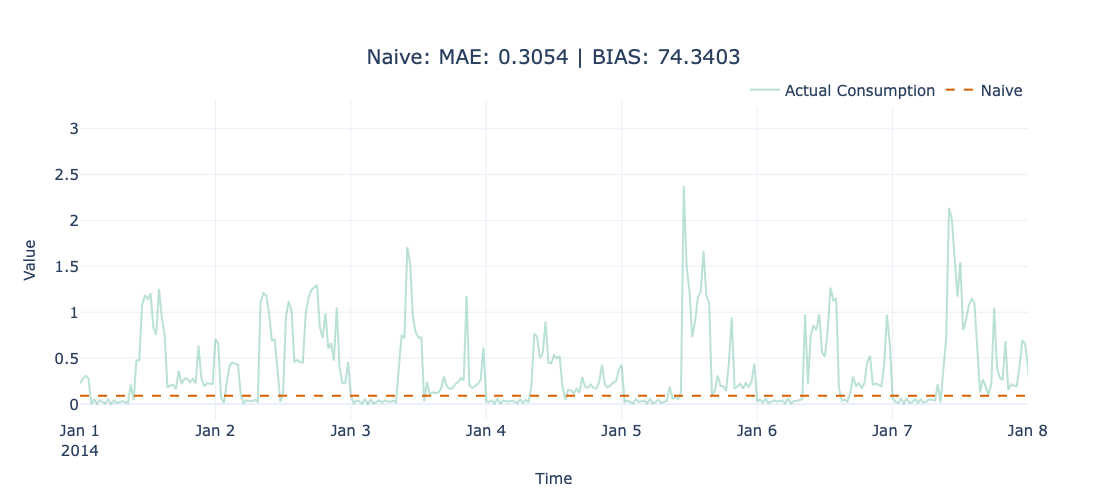

In [21]:
model_name = ['Naive']
model_display_name = ['Naive']

fig = plot_forecast(results, forecast_columns=model_name, forecast_display_names=model_display_name, timestamp_col ='timestamp')
fig = format_plot(fig, title=f"{model_name[0]}: "\
                  f"MAE: {metrics.loc[metrics.Model==model_name[0]][['mae']].iloc[0].item():.4f} | "\
                  # f"MASE: {metrics.loc[metrics.Model==model_name[0]][['mase']].iloc[0].item():.4f} | "\
                  f"BIAS: {metrics.loc[metrics.Model==model_name[0]][['forecast_bias']].iloc[0].item():.4f}")
fig.update_xaxes(type="date", range=["2014-01-01", "2014-01-08"])
#fig.write_image("imgs/chapter_4/naive.png")
fig.show()

### Seasonal Naïve Forecast

In [22]:
results, metrics = (
    evaluate_performance(
        ts_train=ts_train, 
        ts_test=ts_val, 
        models = [SeasonalNaive(season_length=48*7)], 
        metrics = [mae, mse, rmse, smape,forecast_bias], 
        freq = freq,
        level = [] ,
        id_col = 'LCLid',
        time_col = 'timestamp',
        target_col = 'energy_consumption',
        h = len(ts_val),
        metric_df=metrics  # Pass None or an existing DataFrame if you want to append results
        )
)

In [23]:
results.head()

,LCLid,timestamp,energy_consumption,SeasonalNaive
0,MAC000193,2014-01-01 00:00:00,0.223,0.026
1,MAC000193,2014-01-01 00:30:00,0.274,0.041
2,MAC000193,2014-01-01 01:00:00,0.308,0.019
3,MAC000193,2014-01-01 01:30:00,0.279,0.011
4,MAC000193,2014-01-01 02:00:00,0.000,0.041


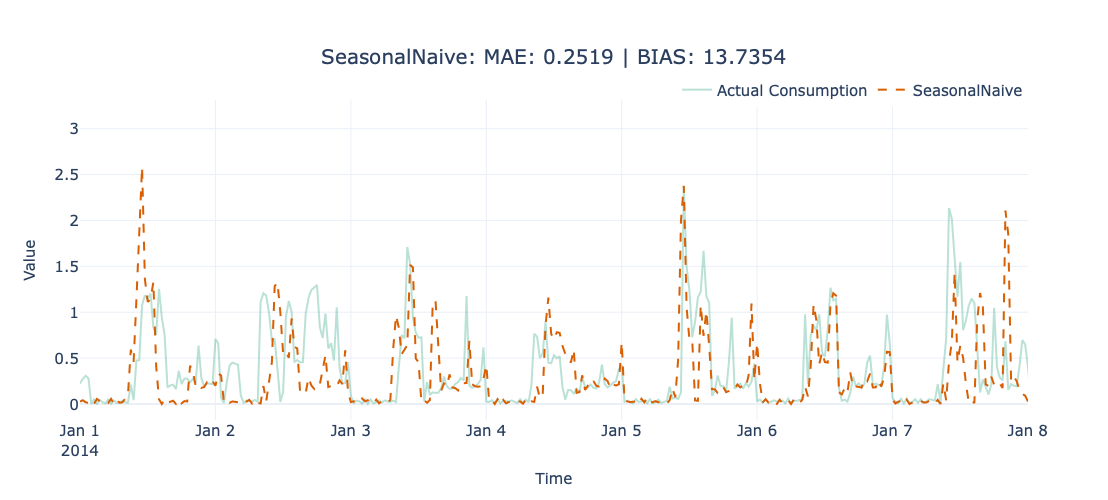

In [24]:
model_name = ['SeasonalNaive']
model_display_name = ['SeasonalNaive']

fig = plot_forecast(results, forecast_columns=model_name, forecast_display_names=model_display_name, timestamp_col ='timestamp')
fig = format_plot(fig, title=f"{model_name[0]}: "\
                  f"MAE: {metrics.loc[metrics.Model==model_name[0]][['mae']].iloc[0].item():.4f} | "\
                  # f"MASE: {metrics.loc[metrics.Model==model_name[0]][['mase']].iloc[0].item():.4f} | "\
                  f"BIAS: {metrics.loc[metrics.Model==model_name[0]][['forecast_bias']].iloc[0].item():.4f}")
fig.update_xaxes(type="date", range=["2014-01-01", "2014-01-08"])
#fig.write_image("imgs/chapter_4/seasonal_naive.png")
fig.show()

### Moving Average Forecast

In [25]:
results, metrics = (
    evaluate_performance(
        ts_train, 
        ts_val, 
        models = [WindowAverage(window_size = 48)], 
        metrics = [mae, mse, rmse, smape,forecast_bias], 
        freq = freq,
        level = [] ,
        id_col = 'LCLid',
        time_col = 'timestamp',
        target_col = 'energy_consumption',
        h = len(ts_val),
        metric_df=metrics  # Pass None or an existing DataFrame if you want to append results
        )
)

In [26]:
metrics

,mae,mse,rmse,smape,forecast_bias,LCLid,Time Elapsed,Model
0,0.305395,0.249304,0.499304,113.588130,74.340254,MAC000193,0.044063,Naive
1,0.251919,0.190827,0.436838,78.738832,13.735403,MAC000193,0.034317,SeasonalNaive
2,0.311723,0.182946,0.427722,100.698209,11.509527,MAC000193,0.033866,WindowAverage


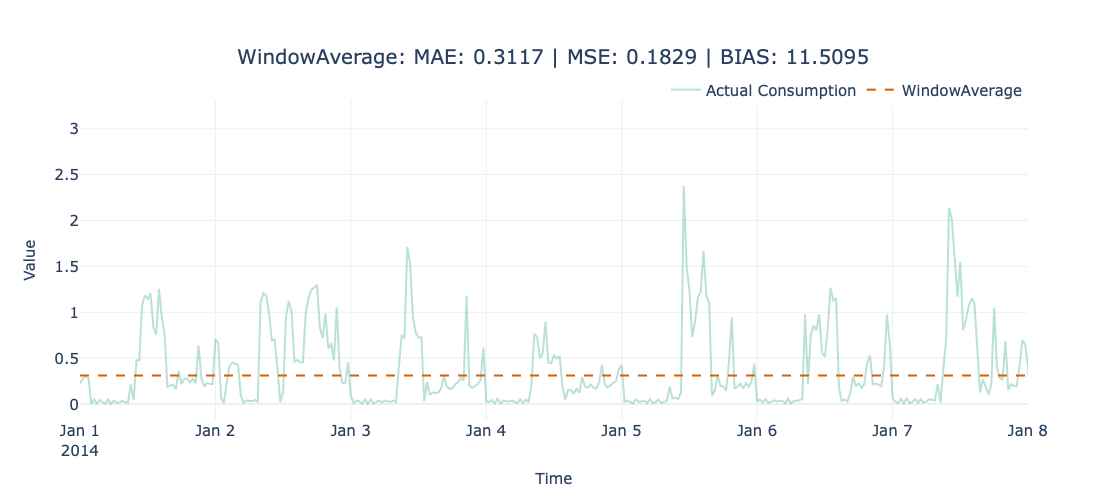

In [27]:
model_name = ['WindowAverage']
model_display_name = ['WindowAverage']

fig = plot_forecast(results, forecast_columns=model_name, forecast_display_names=model_display_name, timestamp_col ='timestamp')
fig = format_plot(fig, title=f"{model_name[0]}: "\
                  f"MAE: {metrics.loc[metrics.Model==model_name[0]][['mae']].iloc[0].item():.4f} | "\
                  f"MSE: {metrics.loc[metrics.Model==model_name[0]][['mse']].iloc[0].item():.4f} | "\
                  # f"MASE: {metrics.loc[metrics.Model==model_name[0]][['mase']].iloc[0].item():.4f} | "\
                  f"BIAS: {metrics.loc[metrics.Model==model_name[0]][['forecast_bias']].iloc[0].item():.4f}")
fig.update_xaxes(type="date", range=["2014-01-01", "2014-01-08"])
#fig.write_image("imgs/chapter_4/window_average.png")
fig.show()

### Exponential Smoothing Forecast

In [28]:
results, metrics = (
    evaluate_performance(
        ts_train, 
        ts_val, 
        models = [ HoltWinters(error_type = 'A', season_length = 48)], 
        metrics = [mae, mse, rmse, smape,forecast_bias], 
        freq = freq,
        level = [] ,
        id_col = 'LCLid',
        time_col = 'timestamp',
        target_col = 'energy_consumption',
        h = len(ts_val),
        metric_df=metrics  # Pass None or an existing DataFrame if you want to append results
        )
)

In [29]:
metrics

,mae,mse,rmse,smape,forecast_bias,LCLid,Time Elapsed,Model
0,0.305395,0.249304,0.499304,113.588130,74.340254,MAC000193,0.044063,Naive
1,0.251919,0.190827,0.436838,78.738832,13.735403,MAC000193,0.034317,SeasonalNaive
2,0.311723,0.182946,0.427722,100.698209,11.509527,MAC000193,0.033866,WindowAverage
3,0.191165,0.100847,0.317565,88.889992,10.440250,MAC000193,4.462489,HoltWinters


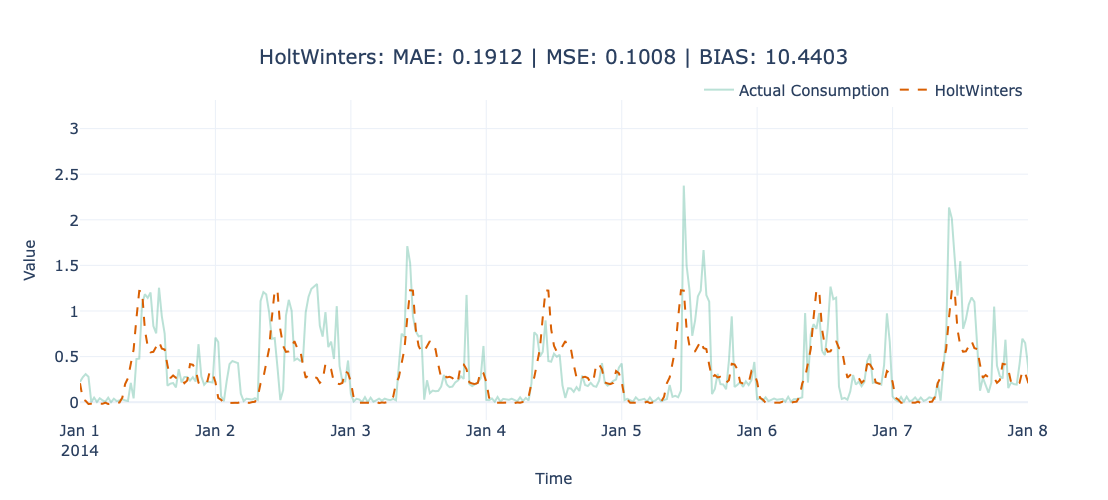

In [30]:
model_name = ['HoltWinters']
model_display_name = ['HoltWinters']

fig = plot_forecast(results, forecast_columns=model_name, forecast_display_names=model_display_name, timestamp_col ='timestamp')
fig = format_plot(fig, title=f"{model_name[0]}: "\
                  f"MAE: {metrics.loc[metrics.Model==model_name[0]][['mae']].iloc[0].item():.4f} | "\
                  f"MSE: {metrics.loc[metrics.Model==model_name[0]][['mse']].iloc[0].item():.4f} | "\
                  # f"MASE: {metrics.loc[metrics.Model==model_name[0]][['mase']].iloc[0].item():.4f} | "\
                  f"BIAS: {metrics.loc[metrics.Model==model_name[0]][['forecast_bias']].iloc[0].item():.4f}")
fig.update_xaxes(type="date", range=["2014-01-01", "2014-01-08"])
#fig.write_image("imgs/chapter_4/ets.png")
fig.show()

In [31]:
results, metrics = (
    evaluate_performance(
        ts_train, 
        ts_val, 
        models = [ AutoETS(model = 'AAA',season_length = 48)], 
        metrics = [mae, mse, rmse, smape,forecast_bias], 
        freq = freq,
        level = [] ,
        id_col = 'LCLid',
        time_col = 'timestamp',
        target_col = 'energy_consumption',
        h = len(ts_val),
        metric_df=metrics  # Pass None or an existing DataFrame if you want to append results
        )
)

In [32]:
results.head()

,LCLid,timestamp,energy_consumption,AutoETS
0,MAC000193,2014-01-01 00:00:00,0.223,0.207815
1,MAC000193,2014-01-01 00:30:00,0.274,0.033957
2,MAC000193,2014-01-01 01:00:00,0.308,0.014500
3,MAC000193,2014-01-01 01:30:00,0.279,-0.019726
4,MAC000193,2014-01-01 02:00:00,0.000,-0.016634


In [33]:
metrics

,mae,mse,rmse,smape,forecast_bias,LCLid,Time Elapsed,Model
0,0.305395,0.249304,0.499304,113.588130,74.340254,MAC000193,0.044063,Naive
1,0.251919,0.190827,0.436838,78.738832,13.735403,MAC000193,0.034317,SeasonalNaive
2,0.311723,0.182946,0.427722,100.698209,11.509527,MAC000193,0.033866,WindowAverage
3,0.191165,0.100847,0.317565,88.889992,10.440250,MAC000193,4.462489,HoltWinters
4,0.191165,0.100847,0.317565,88.889992,10.440250,MAC000193,4.374005,AutoETS


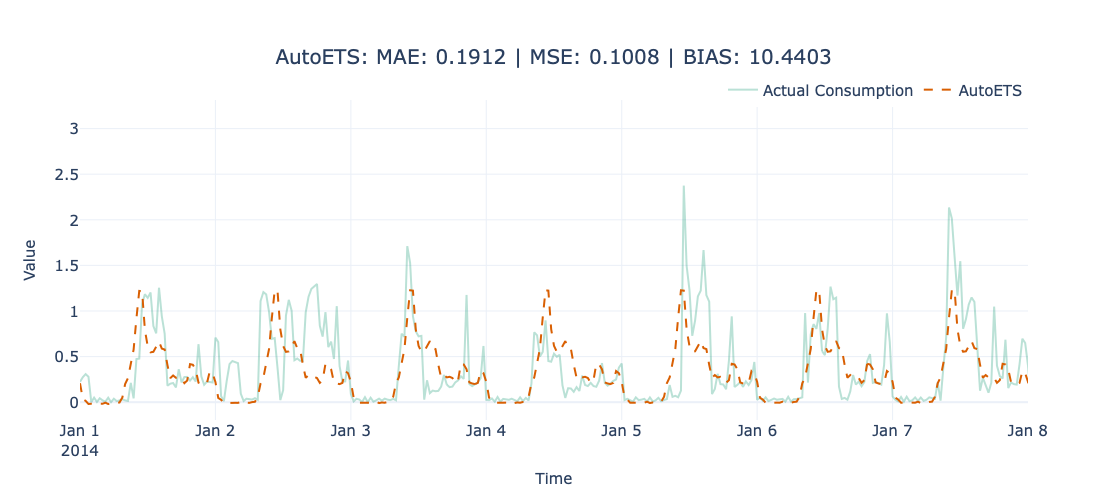

In [34]:
model_name = ['AutoETS']
model_display_name = ['AutoETS']

fig = plot_forecast(results, forecast_columns=model_name, forecast_display_names=model_display_name, timestamp_col ='timestamp')
fig = format_plot(fig, title=f"{model_name[0]}: "\
                  f"MAE: {metrics.loc[metrics.Model==model_name[0]][['mae']].iloc[0].item():.4f} | "\
                  f"MSE: {metrics.loc[metrics.Model==model_name[0]][['mse']].iloc[0].item():.4f} | "\
                  # f"MASE: {metrics.loc[metrics.Model==model_name[0]][['mase']].iloc[0].item():.4f} | "\
                  f"BIAS: {metrics.loc[metrics.Model==model_name[0]][['forecast_bias']].iloc[0].item():.4f}")
fig.update_xaxes(type="date", range=["2014-01-01", "2014-01-08"])
#fig.write_image("imgs/chapter_4/ets.png")
fig.show()

### ARIMA

In [35]:
results, metrics = (
    evaluate_performance(
        ts_train, 
        ts_val, 
        models = [ ARIMA(order = (2,1,1), seasonal_order = (1,1,1), season_length = 48)],
        #models = [ ARIMA(order = (0,1,2), seasonal_order = (0,0,2), season_length = 48)], 
        metrics = [mae, mse, rmse, smape,forecast_bias], 
        freq = freq,
        level = [] ,
        id_col = 'LCLid',
        time_col = 'timestamp',
        target_col = 'energy_consumption',
        h = len(ts_val),
        metric_df=metrics  # Pass None or an existing DataFrame if you want to append results
        )
)

In [36]:
metrics

,mae,mse,rmse,smape,forecast_bias,LCLid,Time Elapsed,Model
0,0.305395,0.249304,0.499304,113.588130,74.340254,MAC000193,0.044063,Naive
1,0.251919,0.190827,0.436838,78.738832,13.735403,MAC000193,0.034317,SeasonalNaive
2,0.311723,0.182946,0.427722,100.698209,11.509527,MAC000193,0.033866,WindowAverage
3,0.191165,0.100847,0.317565,88.889992,10.440250,MAC000193,4.462489,HoltWinters
4,0.191165,0.100847,0.317565,88.889992,10.440250,MAC000193,4.374005,AutoETS
5,0.203777,0.106593,0.326486,98.830849,25.493792,MAC000193,27.414718,ARIMA


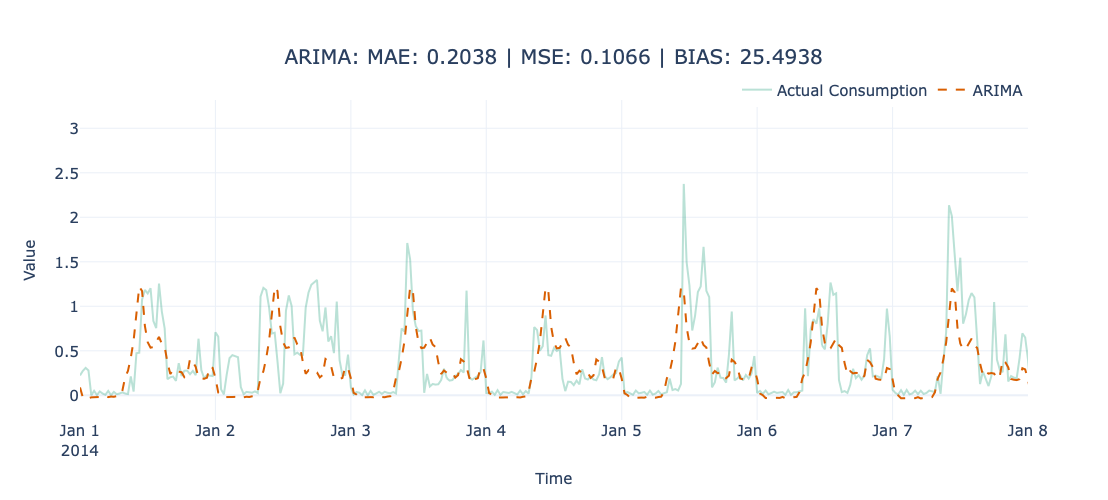

In [37]:
model_name = ['ARIMA']
model_display_name = ['ARIMA']

fig = plot_forecast(results, forecast_columns=model_name, forecast_display_names=model_display_name, timestamp_col ='timestamp')
fig = format_plot(fig, title=f"{model_name[0]}: "\
                  f"MAE: {metrics.loc[metrics.Model==model_name[0]][['mae']].iloc[0].item():.4f} | "\
                  f"MSE: {metrics.loc[metrics.Model==model_name[0]][['mse']].iloc[0].item():.4f} | "\
                  # f"MASE: {metrics.loc[metrics.Model==model_name[0]][['mase']].iloc[0].item():.4f} | "\
                  f"BIAS: {metrics.loc[metrics.Model==model_name[0]][['forecast_bias']].iloc[0].item():.4f}")
fig.update_xaxes(type="date", range=["2014-01-01", "2014-01-08"])
#fig.write_image("imgs/chapter_4/ARIMA.png")
fig.show()

### Sample Auto ARIMA

In [38]:
sf = StatsForecast(
    models=[AutoARIMA( max_p = 2, max_d=1, max_q = 2, max_P=2, max_D = 1, max_Q = 2, 
                      start_p = 1, start_q = 1, start_P = 1, start_Q = 1, stepwise = True, season_length=48)],
    freq=freq,
    n_jobs=-1,
    fallback_model = Naive()
)

y_pred = sf.fit( 
                  
                    df=ts_train,        
                    id_col = 'LCLid',
                    time_col = 'timestamp',
                    target_col = 'energy_consumption',

                    )
sf.fitted_[0,0].model_

{'coef': {'ma1': -0.3800860259287881,
  'ma2': -0.25121043423759143,
  'sma1': 0.12994916259115386,
  'sma2': 0.10457506307998474},
 'sigma2': 0.05918682446360682,
 'var_coef': array([[2.85013966e-05, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 2.85013966e-05, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 2.85013966e-05, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.85013966e-05]]),
 'mask': array([ True,  True,  True,  True]),
 'loglik': -188.90468199400493,
 'aic': 387.80936398800986,
 'arma': (0, 2, 0, 2, 48, 1, 0),
 'residuals': array([ 0.000386  , -0.19388219, -0.18463886, ..., -0.31808833,
        -0.35434812, -0.15943591]),
 'code': 2,
 'n_cond': 0,
 'nobs': 35086,
 'model': {'phi': array([], dtype=float64),
  'theta': array([-0.38008603, -0.25121043,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.     

In [39]:
# {'coef': {'ma1': -0.3800676288610244,
#   'ma2': -0.25121322485842584,
#   'sma1': 0.1300139905884248,
#   'sma2': 0.1045851891918472},
#  'sigma2': 0.05918752833035802,
#  'var_coef': array([[ 7.04752468e-07,  9.11329831e-07,  2.55693473e-07,
#          -1.87114423e-06],
#         [ 9.11329831e-07,  7.41876851e-06, -3.18464778e-07,
#          -8.00782484e-06],
#         [ 2.55693473e-07, -3.18464778e-07,  5.50841803e-07,
#          -4.88097177e-07],
#         [-1.87114423e-06, -8.00782484e-06, -4.88097177e-07,
#           1.03626760e-05]]),
#  'mask': array([ True,  True,  True,  True]),
#  'loglik': -188.2911979664168,
#  'aic': 386.5823959328336,
#  'arma': (0, 2, 0, 2, 48, 1, 0),
#  'residuals': array([ 0.000368  ,  0.01585512, -0.19137661, ..., -0.3180852 ,
#         -0.35435519, -0.1594367 ]),
#  'code': 2,
#  'n_cond': 0,
#  'nobs': 35087,
# ...
#  'bic': 428.9103257852313,
#  'aicc': 386.58410626036135,
#  'ic': None,
#  'xreg': None,
#  'x': array([0.368, 0.386, 0.17 , ..., 0.147, 0.111, 0.09 ], dtype=float32),
#  'lambda': None}

### Theta

In [40]:
results, metrics = (
    evaluate_performance(
        ts_train, 
        ts_val, 
        models = [ Theta(season_length =48, decomposition_type = 'additive' )], 
        metrics = [mae, mse, rmse, smape,forecast_bias], 
        freq = freq,
        level = [] ,
        id_col = 'LCLid',
        time_col = 'timestamp',
        target_col = 'energy_consumption',
        h = len(ts_val),
        metric_df=metrics  # Pass None or an existing DataFrame if you want to append results
        )
)

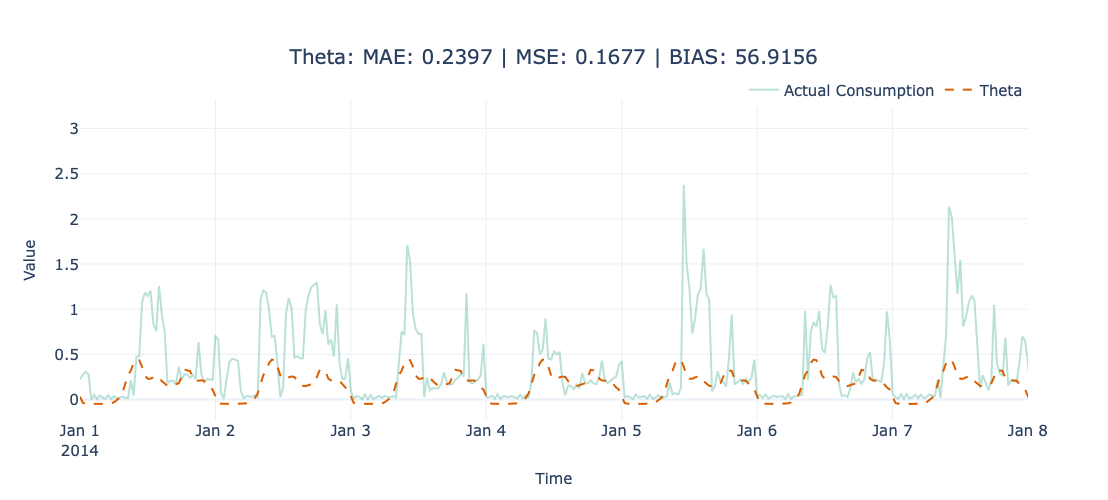

In [47]:
model_name = ['Theta']
model_display_name = ['Theta']

fig = plot_forecast(results, forecast_columns=model_name, forecast_display_names=model_display_name, timestamp_col ='timestamp')
fig = format_plot(fig, title=f"{model_name[0]}: "\
                  f"MAE: {metrics.loc[metrics.Model==model_name[0]][['mae']].iloc[0].item():.4f} | "\
                  f"MSE: {metrics.loc[metrics.Model==model_name[0]][['mse']].iloc[0].item():.4f} | "\
                  # f"MASE: {metrics.loc[metrics.Model==model_name[0]][['mase']].iloc[0].item():.4f} | "\
                  f"BIAS: {metrics.loc[metrics.Model==model_name[0]][['forecast_bias']].iloc[0].item():.4f}")
fig.update_xaxes(type="date", range=["2014-01-01", "2014-01-08"])
#fig.write_image("imgs/chapter_4/auto_theta.png")
fig.show()

In [48]:
metrics

,mae,mse,rmse,smape,forecast_bias,LCLid,Time Elapsed,Model
0,0.305395,0.249304,0.499304,113.588130,74.340254,MAC000193,0.032101,Naive
1,0.251919,0.190827,0.436838,78.738832,13.735403,MAC000193,0.034345,SeasonalNaive
2,0.311723,0.182946,0.427722,100.698209,11.509527,MAC000193,0.033974,WindowAverage
3,0.191165,0.100847,0.317565,88.889992,10.440250,MAC000193,4.397595,HoltWinters
4,0.191165,0.100847,0.317565,88.889992,10.440250,MAC000193,4.463997,AutoETS
5,0.203777,0.106593,0.326486,98.830849,25.493792,MAC000193,27.985500,ARIMA
6,0.239729,0.167723,0.409540,104.388940,56.915551,MAC000193,29.837834,Theta


### TBATS

In [54]:
help(TBATS)

Help on class TBATS in module statsforecast.models:

class TBATS(AutoTBATS)
 |  TBATS(season_length: Union[int, List[int]], use_boxcox: Optional[bool] = True, bc_lower_bound: float = 0.0, bc_upper_bound: float = 1.0, use_trend: Optional[bool] = True, use_damped_trend: Optional[bool] = False, use_arma_errors: bool = False, alias: str = 'TBATS')
 |  
 |  Trigonometric Box-Cox transform, ARMA errors, Trend and Seasonal components (TBATS) model.
 |  
 |  TBATS is an innovations state space model framework used for forecasting time series with multiple seasonalities. It uses a Box-Cox tranformation, ARMA errors, and a trigonometric representation of the seasonal patterns based on Fourier series.
 |  
 |  The name TBATS is an acronym for the key features of the model: Trigonometric, Box-Cox transform, ARMA errors, Trend, and Seasonal components.
 |  
 |  References
 |  ----------
 |  - [De Livera, A. M., Hyndman, R. J., & Snyder, R. D. (2011). Forecasting time series with complex seasonal pa

In [56]:
sf = StatsForecast(
    models=[TBATS(season_length  = 48, use_trend=True, use_damped_trend=True)],
    freq=freq,
    n_jobs=2
)

y_pred = sf.fit( 
                  
                    df=ts_train,        
                    id_col = 'LCLid',
                    time_col = 'timestamp',
                    target_col = 'energy_consumption',

                    )
sf.fitted_[0,0].model_

{'fitted': array([[0.21675801, 0.22634627, 0.14564077, ..., 0.29199521, 0.20381533,
         0.13827733]]),
 'errors': array([[ 0.16924199, -0.05634627, -0.12464077, ..., -0.14499521,
         -0.09281533, -0.04827733]]),
 'sigma2': 0.05354782155588333,
 'aic': 264558.044550254,
 'optim_params': array([ 6.29829034e-01, -1.55662965e-01,  8.00000000e-01, -1.62957623e-07,
         1.03745182e-08]),
 'F': array([[ 1.        ,  0.8       ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.8       ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.    

In [57]:
sf = StatsForecast(
    models=[AutoTBATS(season_length  = 48, use_trend=True, use_damped_trend=True)],
    freq=freq,
    n_jobs=2
)

y_pred = sf.fit( 
                  
                    df=ts_train,        
                    id_col = 'LCLid',
                    time_col = 'timestamp',
                    target_col = 'energy_consumption',

                    )
sf.fitted_[0,0].model_

{'fitted': array([[0.21675801, 0.22847479, 0.13099331, ..., 0.13869745, 0.23538024,
         0.26338134]]),
 'errors': array([[ 0.16924199, -0.05847479, -0.10999331, ...,  0.00830255,
         -0.12438024, -0.17338134]]),
 'sigma2': 0.052778049663679875,
 'aic': 264077.99400773627,
 'optim_params': array([ 5.31279298e-01, -1.30742138e-01,  8.00000000e-01,  3.12121394e-05,
        -2.17383223e-05, -2.02344619e-01, -3.19241243e-02, -3.04921250e-02,
        -3.65932082e-02, -9.85851186e-02,  2.93189353e-01, -1.73917290e-03]),
 'F': array([[ 1.00000000e+00,  8.00000000e-01,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.

In [59]:
results, metrics = (
    evaluate_performance(
        ts_train, 
        ts_val, 
        models = [ TBATS(season_length = [48])], 
        metrics = [mae, mse, rmse, smape,forecast_bias], 
        freq = freq,
        level = [] ,
        id_col = 'LCLid',
        time_col = 'timestamp',
        target_col = 'energy_consumption',
        h = len(ts_val),
        metric_df=metrics  # Pass None or an existing DataFrame if you want to append results
        )
)

In [60]:
metrics

,mae,mse,rmse,smape,forecast_bias,LCLid,Time Elapsed,Model
0,0.305395,0.249304,0.499304,113.588130,74.340254,MAC000193,0.044063,Naive
1,0.251919,0.190827,0.436838,78.738832,13.735403,MAC000193,0.034317,SeasonalNaive
2,0.311723,0.182946,0.427722,100.698209,11.509527,MAC000193,0.033866,WindowAverage
3,0.191165,0.100847,0.317565,88.889992,10.440250,MAC000193,4.462489,HoltWinters
4,0.191165,0.100847,0.317565,88.889992,10.440250,MAC000193,4.374005,AutoETS
5,0.203777,0.106593,0.326486,98.830849,25.493792,MAC000193,27.414718,ARIMA
6,0.239729,0.167723,0.409540,104.388940,56.915551,MAC000193,30.521310,Theta
7,0.239729,0.167723,0.409540,104.388940,56.915551,MAC000193,29.076225,Theta
8,0.510284,0.416502,0.645370,176.739550,144.036078,MAC000193,2.005178,TBATS


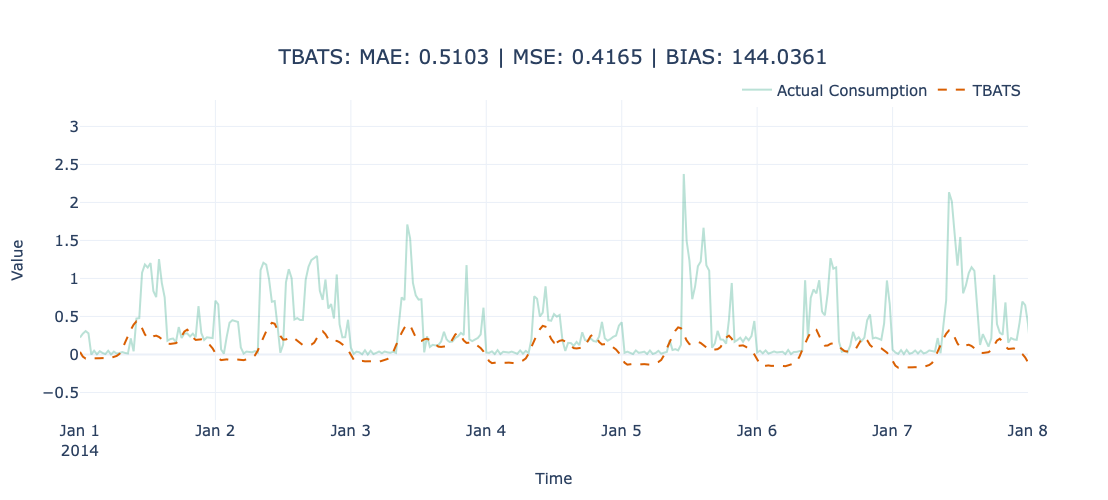

In [61]:
model_name = ['TBATS']
model_display_name = ['TBATS']

fig = plot_forecast(results, forecast_columns=model_name, forecast_display_names=model_display_name, timestamp_col ='timestamp')
fig = format_plot(fig, title=f"{model_name[0]}: "\
                  f"MAE: {metrics.loc[metrics.Model==model_name[0]][['mae']].iloc[0].item():.4f} | "\
                  f"MSE: {metrics.loc[metrics.Model==model_name[0]][['mse']].iloc[0].item():.4f} | "\
                  # f"MASE: {metrics.loc[metrics.Model==model_name[0]][['mase']].iloc[0].item():.4f} | "\
                  f"BIAS: {metrics.loc[metrics.Model==model_name[0]][['forecast_bias']].iloc[0].item():.4f}")
fig.update_xaxes(type="date", range=["2014-01-01", "2014-01-08"])
#fig.write_image("imgs/chapter_4/auto_tbats.png")
fig.show()

### MSTL

In [62]:
results, metrics = (
    evaluate_performance(
        ts_train, 
        ts_val, 
        models = [ MSTL(season_length = 48)], 
        metrics = [mae, mse, rmse, smape,forecast_bias], 
        freq = freq,
        level = [] ,
        id_col = 'LCLid',
        time_col = 'timestamp',
        target_col = 'energy_consumption',
        h = len(ts_val),
        metric_df=metrics  # Pass None or an existing DataFrame if you want to append results
        )
)

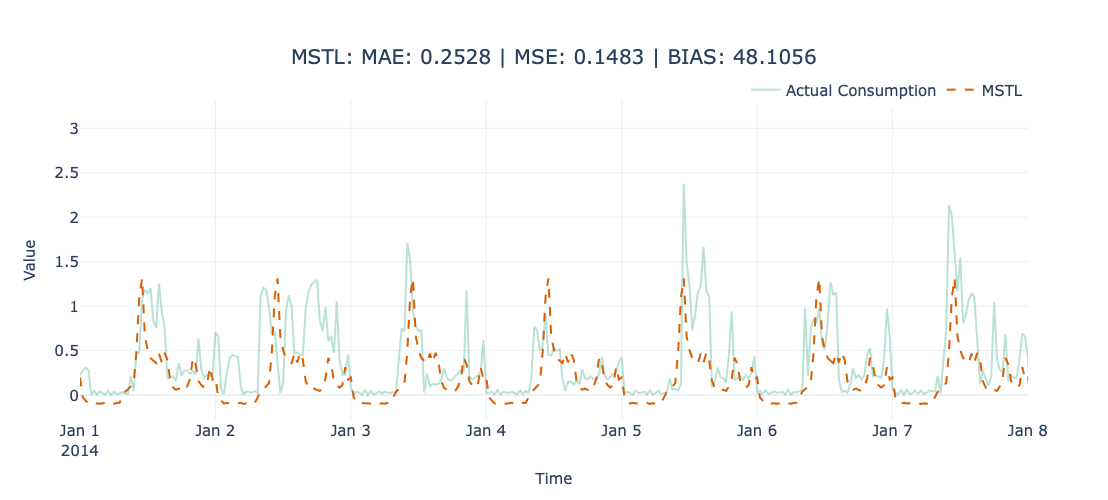

In [63]:
model_name = ['MSTL']
model_display_name = ['MSTL']

fig = plot_forecast(results, forecast_columns=model_name, forecast_display_names=model_display_name, timestamp_col ='timestamp')
fig = format_plot(fig, title=f"{model_name[0]}: "\
                  f"MAE: {metrics.loc[metrics.Model==model_name[0]][['mae']].iloc[0].item():.4f} | "\
                  f"MSE: {metrics.loc[metrics.Model==model_name[0]][['mse']].iloc[0].item():.4f} | "\
                  # f"MASE: {metrics.loc[metrics.Model==model_name[0]][['mase']].iloc[0].item():.4f} | "\
                  f"BIAS: {metrics.loc[metrics.Model==model_name[0]][['forecast_bias']].iloc[0].item():.4f}")
fig.update_xaxes(type="date", range=["2014-01-01", "2014-01-08"])
#fig.write_image("imgs/chapter_4/auto_tbats.png")
fig.show()

In [65]:
metric_styled = metrics.reset_index(drop=True).style.format({
            "mae": "{:.3f}", 
            "mse": "{:.3f}",  
            "rmse": "{:.3f}", 
            "smape": "{:.3f}",            
            "forecast_bias": "{:.2f}%"}).highlight_min(color='lightgreen', subset=["mae","mse","rmse","smape","Time Elapsed"])
display(metric_styled)

,mae,mse,rmse,smape,forecast_bias,LCLid,Time Elapsed,Model
0,0.305,0.249,0.499,113.588,74.34%,MAC000193,0.044063,Naive
1,0.252,0.191,0.437,78.739,13.74%,MAC000193,0.034317,SeasonalNaive
2,0.312,0.183,0.428,100.698,11.51%,MAC000193,0.033866,WindowAverage
3,0.191,0.101,0.318,88.890,10.44%,MAC000193,4.462489,HoltWinters
4,0.191,0.101,0.318,88.890,10.44%,MAC000193,4.374005,AutoETS
5,0.204,0.107,0.326,98.831,25.49%,MAC000193,27.414718,ARIMA
6,0.240,0.168,0.410,104.389,56.92%,MAC000193,30.521310,Theta
7,0.240,0.168,0.410,104.389,56.92%,MAC000193,29.076225,Theta
8,0.510,0.417,0.645,176.740,144.04%,MAC000193,2.005178,TBATS
9,0.253,0.148,0.385,117.314,48.11%,MAC000193,0.939861,MSTL


## Validation Set

### Running Baseline Forecast for All Consumers

In [67]:
ids = list(train_df.LCLid.unique()[:500]) # slicing dataframe for the sake of time.  May want to consider setting this low if working on a slower machine

train_df = train_df[train_df.LCLid.isin(ids)]
val_df = val_df[val_df.LCLid.isin(ids)]
test_df = test_df[test_df.LCLid.isin(ids)]

print("Length of validation Data: ", len(val_df[val_df.LCLid =='MAC000948'].LCLid))

Length of validation Data:  1488


### Forecasting for Validation Period for TBATS and AutoETS

In [69]:
validation_models =  [AutoETS(model = 'AAA',season_length = 48), 
                      TBATS(season_length  = 48)]

# validation_models = [Naive()]
validation_models_names = [model.__class__.__name__ for model in validation_models]
metric_df = pd.DataFrame([])
h_val = 1488

In [70]:
aggval_metrics = pd.DataFrame()

baseline_val_pred_df, aggval_metrics = (
    evaluate_performance(
        train_df[["LCLid","timestamp","energy_consumption"]], 
        val_df[["LCLid","timestamp","energy_consumption"]], 
        models =validation_models, 
        metrics = [mae, mse, rmse, smape,forecast_bias], 
        freq = freq,
        level = [] ,
        id_col = 'LCLid',
        time_col = 'timestamp',
        target_col = 'energy_consumption',
        h = h_val,
        metric_df = aggval_metrics
        )
)

/opt/anaconda3/envs/MTSP/lib/python3.10/site-packages/statsforecast/tbats.py:949: UserWarning: Data contains zero or negative values, disabling Box-Cox transformation.
  warnings.warn(
/opt/anaconda3/envs/MTSP/lib/python3.10/site-packages/statsforecast/tbats.py:949: UserWarning: Data contains zero or negative values, disabling Box-Cox transformation.
  warnings.warn(
/opt/anaconda3/envs/MTSP/lib/python3.10/site-packages/statsforecast/tbats.py:949: UserWarning: Data contains zero or negative values, disabling Box-Cox transformation.
  warnings.warn(
/opt/anaconda3/envs/MTSP/lib/python3.10/site-packages/statsforecast/tbats.py:949: UserWarning: Data contains zero or negative values, disabling Box-Cox transformation.
  warnings.warn(
/opt/anaconda3/envs/MTSP/lib/python3.10/site-packages/statsforecast/tbats.py:949: UserWarning: Data contains zero or negative values, disabling Box-Cox transformation.
  warnings.warn(
/opt/anaconda3/envs/MTSP/lib/python3.10/site-packages/statsforecast/tbats.p

#### Evaluation of Baseline Forecast

In [71]:
aggval_metrics.head()

,mae,mse,rmse,smape,forecast_bias,LCLid,Time Elapsed,Model
0,0.167747,0.050541,0.224814,59.395635,-26.861671,MAC000768,54.585262,AutoETS
1,0.107071,0.034325,0.185269,34.775889,17.419682,MAC000948,54.585262,AutoETS
2,0.184768,0.051710,0.227398,42.697275,-31.349871,MAC003299,54.585262,AutoETS
3,0.142319,0.040731,0.201820,30.385882,-5.956137,MAC003157,54.585262,AutoETS
4,0.191165,0.100847,0.317565,88.889992,10.440250,MAC000193,54.585262,AutoETS


In [72]:
baseline_val_pred_df[baseline_val_pred_df.LCLid =='MAC000173']

,LCLid,timestamp,energy_consumption,AutoETS,TBATS
66960,MAC000173,2014-01-01 00:00:00,0.137,0.099094,0.387202
66961,MAC000173,2014-01-01 00:30:00,0.092,0.086353,0.385755
66962,MAC000173,2014-01-01 01:00:00,0.106,0.078603,0.385738
66963,MAC000173,2014-01-01 01:30:00,0.138,0.075427,0.386691
66964,MAC000173,2014-01-01 02:00:00,0.045,0.075493,0.387184
...,...,...,...,...,...
68443,MAC000173,2014-01-31 21:30:00,0.255,0.264875,1.417739
68444,MAC000173,2014-01-31 22:00:00,0.271,0.255509,1.364563
68445,MAC000173,2014-01-31 22:30:00,0.597,0.213923,1.317268
68446,MAC000173,2014-01-31 23:00:00,0.202,0.143233,1.284239


In [74]:
aggval_metrics[aggval_metrics.Model =='TBATS'].sort_values(by='mae', ascending = False)

,mae,mse,rmse,smape,forecast_bias,LCLid,Time Elapsed,Model
226,6.308276,76.497559,8.746288,165.538955,-1673.530197,MAC003784,67.980598,TBATS
166,1.606418,4.474939,2.115405,164.966357,-1391.518784,MAC005463,67.980598,TBATS
221,1.520077,3.431528,1.852438,97.604746,-201.156068,MAC001009,67.980598,TBATS
187,1.145527,1.601909,1.265665,199.869895,445.297384,MAC000633,67.980598,TBATS
181,0.988872,1.407022,1.186180,162.143505,108.964884,MAC002324,67.980598,TBATS
...,...,...,...,...,...,...,...,...
231,0.024379,0.000804,0.028359,18.137731,11.103661,MAC000154,67.980598,TBATS
290,0.023623,0.003772,0.061414,30.451027,2.912170,MAC000751,67.980598,TBATS
270,0.021110,0.000601,0.024510,66.927111,33.549145,MAC002925,67.980598,TBATS
206,0.017089,0.000822,0.028673,37.754494,11.775599,MAC001169,67.980598,TBATS


In [76]:
autoets_val_metric_df = aggval_metrics[aggval_metrics.Model =='AutoETS']

overall_metrics_val_autoets = {
    "Algorithm": "AutoETS",
    "MAE": mae(baseline_val_pred_df.energy_consumption.values, baseline_val_pred_df.AutoETS.values),
    "MSE": mse(baseline_val_pred_df.energy_consumption.values, baseline_val_pred_df.AutoETS.values),
    # "meanMASE": autoets_val_metric_df.mase.mean(),
    "Forecast Bias": forecast_bias(baseline_val_pred_df.energy_consumption.values, baseline_val_pred_df.AutoETS.values)
}
overall_metrics_val_autoets

{'Algorithm': 'AutoETS',
 'MAE': 0.11971782,
 'MSE': 0.057770576,
 'Forecast Bias': 4.269564896821976}

In [79]:
tbats_val_metric_df = aggval_metrics[aggval_metrics.Model =='TBATS']
overall_metrics_val_tbats = {
    "Algorithm": "TBATS",
    "MAE": mae(baseline_val_pred_df.energy_consumption.values, baseline_val_pred_df.TBATS.values),
    "MSE": mse(baseline_val_pred_df.energy_consumption.values, baseline_val_pred_df.TBATS.values),
    # "meanMASE": tbats_val_metric_df.mase.mean(),
    "Forecast Bias": forecast_bias(baseline_val_pred_df.energy_consumption.values, baseline_val_pred_df.TBATS.values)
}
overall_metrics_val_tbats

{'Algorithm': 'TBATS',
 'MAE': 0.2799654,
 'MSE': 0.7091829,
 'Forecast Bias': -25.215700268745422}

In [81]:
baseline_val_metrics_df = pd.DataFrame([overall_metrics_val_autoets, overall_metrics_val_tbats])

display(baseline_val_metrics_df.style.format({"MAE": "{:.3f}", 
                          "MSE": "{:.3f}", 
                          # "meanMASE": "{:.3f}", 
                          "Forecast Bias": "{:.2f}%"}).highlight_min(color='lightgreen', subset=["MAE","MSE"]))

,Algorithm,MAE,MSE,Forecast Bias
0,AutoETS,0.120,0.058,4.27%
1,TBATS,0.280,0.709,-25.22%


In [82]:
baseline_val_metrics_df.head()

,Algorithm,MAE,MSE,Forecast Bias
0,AutoETS,0.119718,0.057771,4.269565
1,TBATS,0.279965,0.709183,-25.215700


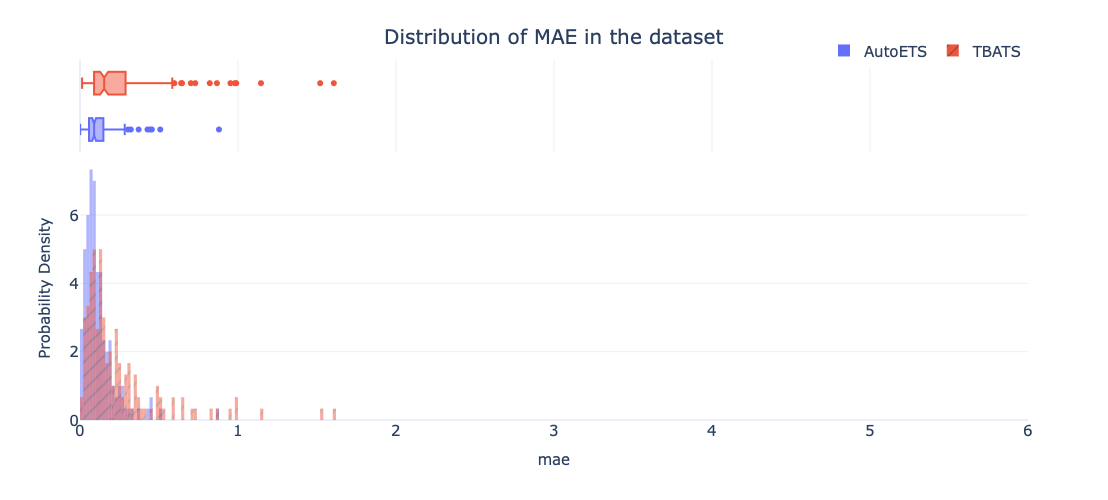

In [84]:
fig = px.histogram(aggval_metrics, 
                   x="mae", 
                   color="Model",
                   pattern_shape="Model", 
                   marginal="box", 
                   nbins=500, 
                   barmode="overlay",
                   histnorm="probability density")
fig = format_plot(fig, xlabel="mae", ylabel="Probability Density", title="Distribution of MAE in the dataset")
fig.update_layout(xaxis_range=[0,6])
# fig.write_image("imgs/chapter_4/mase_dist.png")
fig.show()

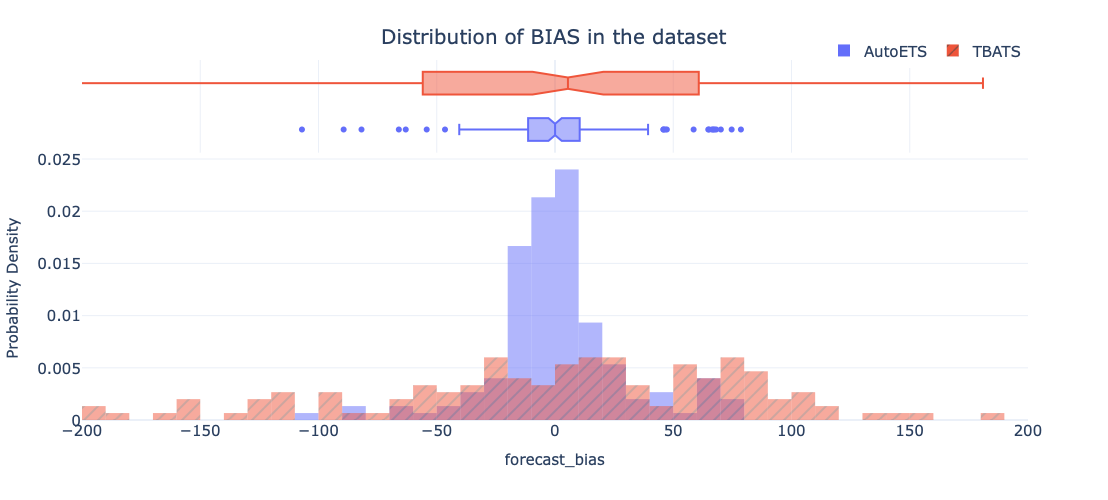

In [85]:
fig = px.histogram(aggval_metrics, 
                   x="forecast_bias", 
                   color="Model",
                   pattern_shape="Model", 
                   marginal="box", 
                   nbins=250, 
                   barmode="overlay",
                   histnorm="probability density")
fig = format_plot(fig, xlabel="forecast_bias", ylabel="Probability Density", title="Distribution of BIAS in the dataset")
fig.update_layout(xaxis_range=[-200,200])
# fig.write_image("imgs/chapter_4/bias_dist.png")
fig.show()

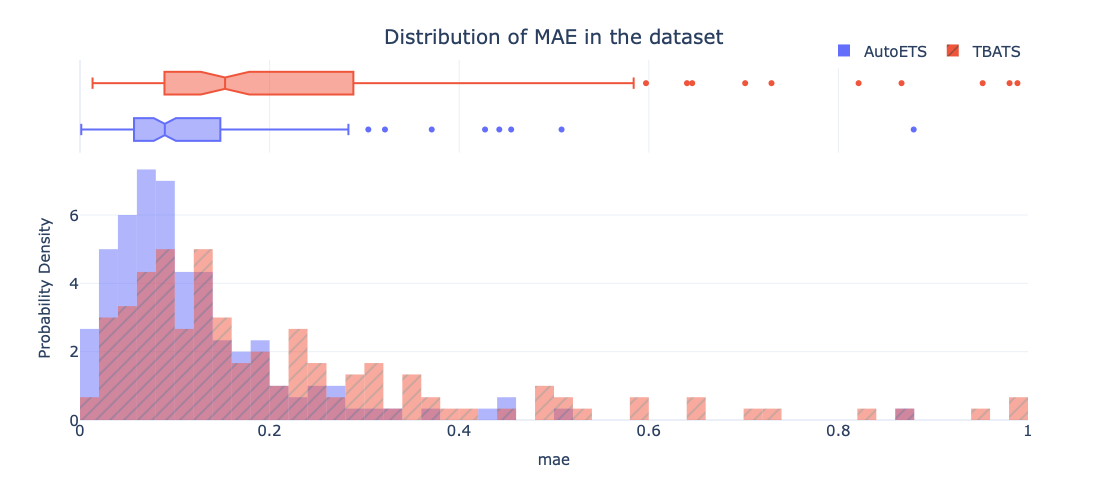

In [86]:
fig = px.histogram(aggval_metrics, 
                   x="mae", 
                   color="Model",
                   pattern_shape="Model", 
                   marginal="box", 
                   nbins=500, 
                   barmode="overlay",
                   histnorm="probability density")
fig = format_plot(fig, xlabel="mae", ylabel="Probability Density", title="Distribution of MAE in the dataset")
fig.update_layout(xaxis_range=[0,1])
# fig.write_image("imgs/chapter_4/mae_dist.png")
fig.show()

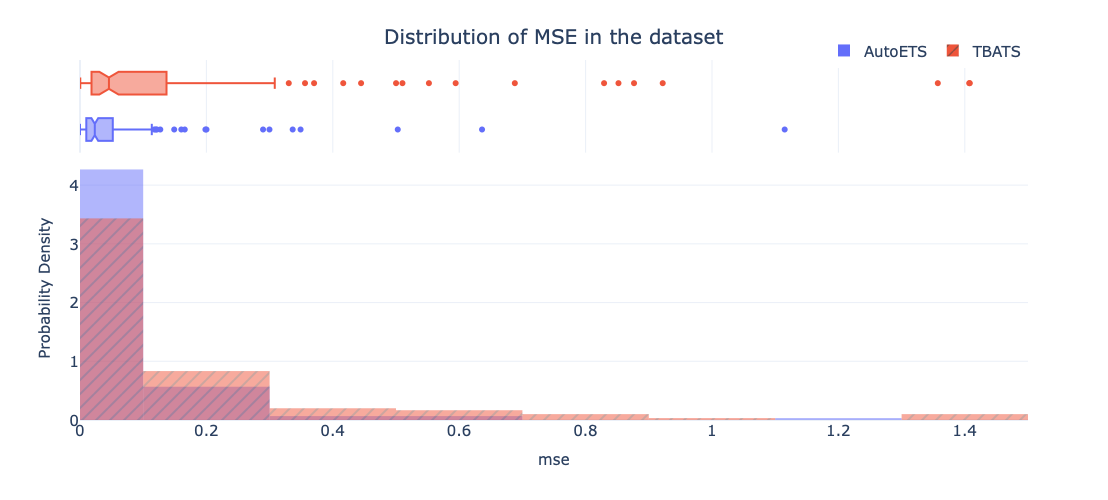

In [87]:
fig = px.histogram(aggval_metrics, 
                   x="mse", 
                   color="Model",
                   pattern_shape="Model", 
                   marginal="box", 
                   nbins=500, 
                   barmode="overlay",
                   histnorm="probability density")
fig = format_plot(fig, xlabel="mse", ylabel="Probability Density", title="Distribution of MSE in the dataset")
fig.update_layout(xaxis_range=[0,1.5])
# fig.write_image("imgs/chapter_4/mse_dist.png")
fig.show()

#### Saving The Baseline Forecasts & Metrics

In [88]:
os.makedirs("data/london_smart_meters/output", exist_ok=True)

output = Path("data/london_smart_meters/output")

baseline_val_pred_df.to_pickle(output/"baseline_val_prediction_df.pkl")
baseline_val_metrics_df.to_pickle(output/"baseline_val_metrics_df.pkl")
aggval_metrics.to_pickle(output/"baseline_val_aggregate_metrics.pkl")

## Test Set

### Forecasting for Test Period

In [99]:
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import rmse as rmse_local
from utilsforecast.losses import mae as mae_local
from utilsforecast.losses import mse as mse_local
from utilsforecast.losses import mase as mase_local

from functools import partial

In [90]:
_train_df = pd.concat([train_df, val_df])
print("Length of training Data: ", len(test_df[test_df.LCLid =='MAC000948'].LCLid))
test_df.tail()

Length of training Data:  1296


,LCLid,timestamp,energy_consumption,frequency
23467,MAC003911,2014-02-27 21:30:00,0.321,30min
23468,MAC003911,2014-02-27 22:00:00,0.270,30min
23469,MAC003911,2014-02-27 22:30:00,0.276,30min
23470,MAC003911,2014-02-27 23:00:00,0.314,30min
23471,MAC003911,2014-02-27 23:30:00,0.320,30min


In [92]:
test_models =  [ AutoETS(model = 'AAA',season_length = 48), TBATS(season_length  = 48)]
h_test = 1296

In [93]:
sf = StatsForecast(
    models=test_models,
    freq=freq,
    n_jobs=-1,
    fallback_model= SeasonalNaive(season_length=48)
)

# sf.fit( df = _train_df[['timestamp', 'LCLid', 'energy_consumption']] ,    
#         id_col = 'LCLid',
#         time_col = 'timestamp',
#         target_col = 'energy_consumption',
#         )

# baseline_test_pred_df = sf.predict( h =1296 )

# Memory efficient predictions
baseline_test_pred_df = sf.forecast(df=_train_df, 
                                        h=h_test, 
                                        level=[],   
                                        id_col = 'LCLid',
                                        time_col = 'timestamp',
                                        target_col = 'energy_consumption',
        )
baseline_test_pred_df = pd.merge(baseline_test_pred_df, test_df[['timestamp',
                                                                 'LCLid',
                                                                 'energy_consumption']],
                                 on = ['LCLid','timestamp'],
                                 how = 'left')

/opt/anaconda3/envs/MTSP/lib/python3.10/site-packages/statsforecast/tbats.py:949: UserWarning: Data contains zero or negative values, disabling Box-Cox transformation.
  warnings.warn(
/opt/anaconda3/envs/MTSP/lib/python3.10/site-packages/statsforecast/tbats.py:949: UserWarning: Data contains zero or negative values, disabling Box-Cox transformation.
  warnings.warn(
/opt/anaconda3/envs/MTSP/lib/python3.10/site-packages/statsforecast/tbats.py:949: UserWarning: Data contains zero or negative values, disabling Box-Cox transformation.
  warnings.warn(
/opt/anaconda3/envs/MTSP/lib/python3.10/site-packages/statsforecast/tbats.py:949: UserWarning: Data contains zero or negative values, disabling Box-Cox transformation.
  warnings.warn(
/opt/anaconda3/envs/MTSP/lib/python3.10/site-packages/statsforecast/tbats.py:949: UserWarning: Data contains zero or negative values, disabling Box-Cox transformation.
  warnings.warn(
/opt/anaconda3/envs/MTSP/lib/python3.10/site-packages/statsforecast/tbats.p

In [94]:
baseline_test_pred_df.head()

,LCLid,timestamp,AutoETS,TBATS,energy_consumption
0,MAC000061,2014-02-01 00:00:00,0.056101,0.019325,0.066
1,MAC000061,2014-02-01 00:30:00,0.039241,0.004128,0.063
2,MAC000061,2014-02-01 01:00:00,0.024739,-0.002761,0.040
3,MAC000061,2014-02-01 01:30:00,0.022753,-0.004277,0.020
4,MAC000061,2014-02-01 02:00:00,0.023229,-0.004180,0.018


In [100]:
fcst_mase = partial(mase_local, seasonality=48)

baseline_test_metrics_df = evaluate(baseline_test_pred_df, 
        metrics=[rmse_local, mae_local, mse_local,fcst_mase],  
        train_df = _train_df[['timestamp', 'LCLid', 'energy_consumption']],      
        id_col = 'LCLid',
        time_col = 'timestamp',
        target_col = 'energy_consumption'
        )

In [101]:
baseline_test_metrics_df.head()

,LCLid,metric,AutoETS,TBATS
0,MAC000061,rmse,0.078926,0.108155
1,MAC000062,rmse,0.169500,0.213092
2,MAC000066,rmse,0.068317,0.124149
3,MAC000086,rmse,0.168439,0.245984
4,MAC000126,rmse,0.104435,0.112129


In [102]:
cols_to_exclude  = ['LCLid', 'metric']
test_columns = [col for col in baseline_test_metrics_df.columns if col not in cols_to_exclude]
test_columns

['AutoETS', 'TBATS']

In [103]:
baseline_test_metrics_df = pd.melt(baseline_test_metrics_df, id_vars = ['LCLid','metric'],value_vars= test_columns, var_name='Algorithm' , value_name='value')
baseline_test_metrics_df = baseline_test_metrics_df.pivot_table(index = ['LCLid','Algorithm'], columns = 'metric', values = 'value').reset_index()
baseline_test_metrics_df.head()

metric,LCLid,Algorithm,mae,mase,mse,rmse
0,MAC000061,AutoETS,0.058033,0.994184,0.006229,0.078926
1,MAC000061,TBATS,0.086817,1.487295,0.011698,0.108155
2,MAC000062,AutoETS,0.091553,1.020420,0.028730,0.169500
3,MAC000062,TBATS,0.135149,1.506322,0.045408,0.213092
4,MAC000066,AutoETS,0.044511,0.844105,0.004667,0.068317


In [104]:
validation_models_names

['AutoETS', 'TBATS']

In [105]:
baseline_test_metrics_df.head()

metric,LCLid,Algorithm,mae,mase,mse,rmse
0,MAC000061,AutoETS,0.058033,0.994184,0.006229,0.078926
1,MAC000061,TBATS,0.086817,1.487295,0.011698,0.108155
2,MAC000062,AutoETS,0.091553,1.020420,0.028730,0.169500
3,MAC000062,TBATS,0.135149,1.506322,0.045408,0.213092
4,MAC000066,AutoETS,0.044511,0.844105,0.004667,0.068317


In [107]:
# from datasetsforecast.losses import *

agg_test_metrics = []  # Initialize an empty list to store the metrics dictionaries

for model in validation_models_names:
    actual_series = baseline_test_pred_df['energy_consumption'].values
    pred_series = baseline_test_pred_df[model].values
    
    # Create a dictionary for the current model's metrics
    agg_test_metrics1 = {
        "Algorithm": model,
        "MAE": mae(actual_series, pred_series),
        "MSE": mse(actual_series, pred_series),
        "meanMASE": baseline_test_metrics_df[baseline_test_metrics_df.Algorithm == model].mase.mean(),
        "Forecast Bias": forecast_bias(actual_series, pred_series),
    }
    
    # Append the dictionary to the list
    agg_test_metrics.append(agg_test_metrics1)
agg_test_metrics_df = pd.DataFrame(agg_test_metrics)
agg_test_metrics_df

,Algorithm,MAE,MSE,meanMASE,Forecast Bias
0,AutoETS,0.119328,0.060436,0.997025,-9.875312
1,TBATS,1.157912,18.414743,9.013659,3.240345


#### Evaluation of Baseline Forecast

In [108]:
display(agg_test_metrics_df.style.format({"MAE": "{:.3f}", 
                          "MSE": "{:.3f}", 
                          "meanMASE": "{:.3f}", 
                          "Forecast Bias": "{:.2f}%"}).highlight_min(color='lightgreen', subset=["MAE","MSE","meanMASE"]))

,Algorithm,MAE,MSE,meanMASE,Forecast Bias
0,AutoETS,0.119,0.060,0.997,-9.88%
1,TBATS,1.158,18.415,9.014,3.24%


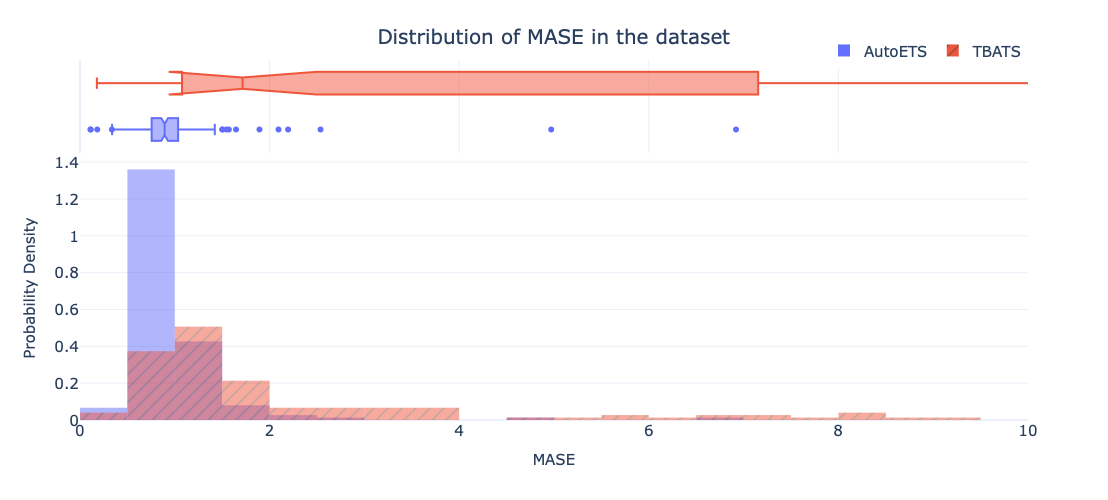

In [109]:
fig = px.histogram(baseline_test_metrics_df, 
                   x="mase", 
                   color="Algorithm",
                   pattern_shape="Algorithm", 
                   marginal="box", 
                   nbins=500, 
                   barmode="overlay",
                   histnorm="probability density")
fig = format_plot(fig, xlabel="MASE", ylabel="Probability Density", title="Distribution of MASE in the dataset")
fig.update_layout(xaxis_range=[0,10])
# fig.write_image("imgs/chapter_4/mase_dist_test.png")
fig.show()

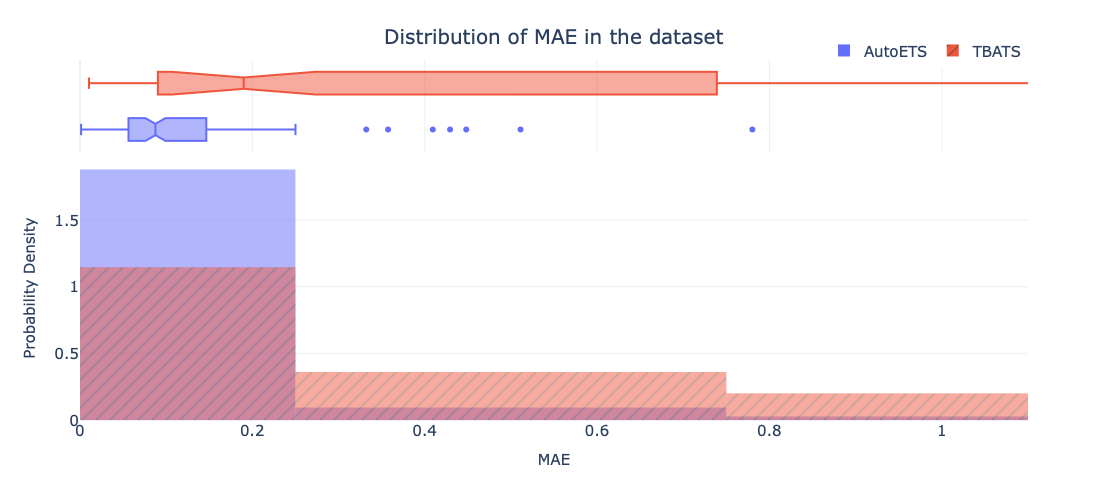

In [110]:
fig = px.histogram(baseline_test_metrics_df, 
                   x="mae", 
                   color="Algorithm",
                   pattern_shape="Algorithm", 
                   marginal="box", 
                   nbins=100, 
                   barmode="overlay",
                   histnorm="probability density")
fig = format_plot(fig, xlabel="MAE", ylabel="Probability Density", title="Distribution of MAE in the dataset")
# fig.write_image("imgs/chapter_4/mae_dist_test.png")
fig.update_layout(xaxis_range=[0,1.1])
fig.show()

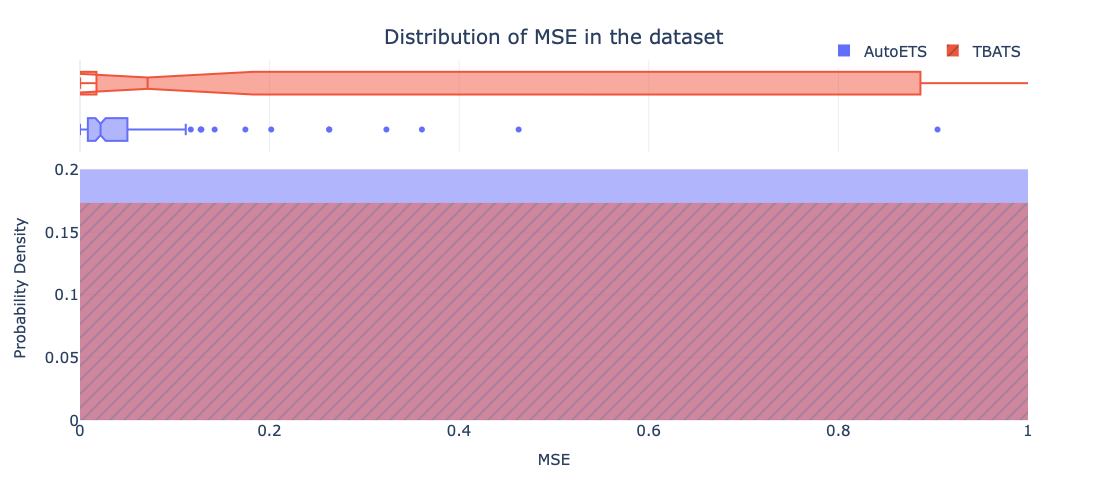

In [111]:
fig = px.histogram(baseline_test_metrics_df, 
                   x="mse", 
                   color="Algorithm",
                   pattern_shape="Algorithm", 
                   marginal="box", 
                   nbins=500, 
                   barmode="overlay",
                   histnorm="probability density")
fig = format_plot(fig, xlabel="MSE", ylabel="Probability Density", title="Distribution of MSE in the dataset")
fig.update_layout(xaxis_range=[0,1])
# fig.write_image("imgs/chapter_4/mse_dist_test.png")
fig.show()

#### Saving The Baseline Forecasts & Metrics

In [112]:
os.makedirs("data/london_smart_meters/output", exist_ok=True)

output = Path("data/london_smart_meters/output")

In [113]:
baseline_test_pred_df.to_pickle(output/"baseline_test_prediction_df.pkl")

baseline_test_metrics_df.to_pickle(output/"baseline_test_metrics_df.pkl")

agg_test_metrics_df.to_pickle(output/"baseline_test_aggregate_metrics.pkl")